# Simulating J

Following the study material and meeting on the 19th of February we will need to approximate the J function. Which gives the reward for this step taking into account all future steps. For this we first need to calculate it for different states

In [1]:
import numpy as np
from pyworld3 import World3
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
# population: p1, p2, p3, p4
# capital: ic, sc
# agriculture: al, pal, uil, lfert
# pollution: ppol
# resource: nr
state_variables = ["p1", "p2", "p3", "p4", "ic", "sc", "al", "pal", "uil", "lfert", "ppol", "nr"]

## Definition of J and proposed reward function

In [3]:
def J_func(reward):
    """ 
    In:
        reward - numpy array: rewards for the simlation
    Out: 
        Array of J function values
    """
    iterations = reward.shape[0]
    J = np.zeros((iterations,1))
    J[iterations-1] = reward[iterations-1]
    for k in range(2,iterations+1):
        # J[n] is the reward at step n plus J[n+1]
        J[iterations-k] = reward[iterations-k] + J[iterations-k+1] 
    return J

def reward_pop(world):
    # reward function, trying simple with population
    return world.pop

### Testing on standard run

In [4]:
world_standard = World3(year_max=2100)
world_standard.set_world3_control()
world_standard.init_world3_constants()
world_standard.init_world3_variables()
world_standard.set_world3_table_functions()
world_standard.set_world3_delay_functions()
world_standard.run_world3(fast=False)

In [5]:
reward = reward_pop(world_standard)
J = J_func(reward)

## Random start
To do this well we need to explore the entire space of possible states of the world3 model. FOr this we will take a randomized start. Exploring the entire state might require too much calculations, a full run takes approximately 1.8 seconds (dependent on computer). only $1000$ full runs will take about half an hour, therefore it might be better to try to only explore more relevant parts of the state space \
Current idea: Draw each state variable that we want to change from a gaussian distribution dependent on how they behave in the standard run. The year can be drawn from a uniform distribution.

In [6]:
def get_mu_sigma(world, variable):
    data = getattr(world, variable)
    mean = np.mean(data) 
    std = np.std(data)
    return mean, std

### Saving values
All values need to be saved and stored some way. There are two parts to this, one storing at runtime. And then storing between runs. \
Between runs it is easiest to store it as a csv file with named columns to easier extract data at a later time. \
Runtime we should use numpy in calculations since it is fast, then create a pandas dataframe that easily can be converted to a csv file. \
Taking this into account when designing the main loop

In [7]:
def generate_initial(total_runs, variables):
    """ 
    In: 
        total_runs - int: total number of simulations to generate initial data for
        variables  - list[String]: the variables that will be initialised randomly using the standard run
    Out:
        initial_variables - list[dictionary<String,float>]: Dictionary with the initial variables 
    """
    array = []
    for _ in range(total_runs):
        dict = {}
        for variable in variables:
            mu, sigma = get_mu_sigma(world_standard, variable)
            value = np.random.normal(mu, sigma)
            while value < 0:
                value = np.random.normal(mu, sigma)
            dict[variable+"i"]=value 
            

        array.append(dict)
    return array

def main_loop(reward_func):
    """ 
    In: 
        reward_func function: function that takes a world3 object as indata and returns an array of rewards
    """
    """
    Need to randomize time, how?
    """
    runs = 100
    variables = state_variables
    initial_values = generate_initial(runs, variables)
    n = 401
    variables.append("time")
    df = pd.DataFrame(np.nan, index=range(n*runs), columns=variables)
    df["J"] = np.nan
    for run in tqdm(range(runs)):
        # running the model
        world3 = World3(year_max=2100)
        world3.set_world3_control()
        world3.init_world3_constants(**initial_values[run])
        world3.init_world3_variables()
        world3.set_world3_table_functions()
        world3.set_world3_delay_functions()
        world3.run_world3(fast=False)

        # reward and J
        reward = reward_func(world3)
        J = J_func(reward)
        df.loc[n*run:n*(run+1)-1, "J"] = J

        # writing to dataframe
        for variable in variables:
            column = getattr(world3, variable)
            df.loc[n*run:n*(run+1)-1, variable] = column
    return df

In [8]:
#main_loop()
def g(world):
    # reward function, trying simple with population
    return world.le

dataframe = main_loop(g)

# sparar till csv fil
dataframe.to_csv("DataTest.csv", index=False)

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


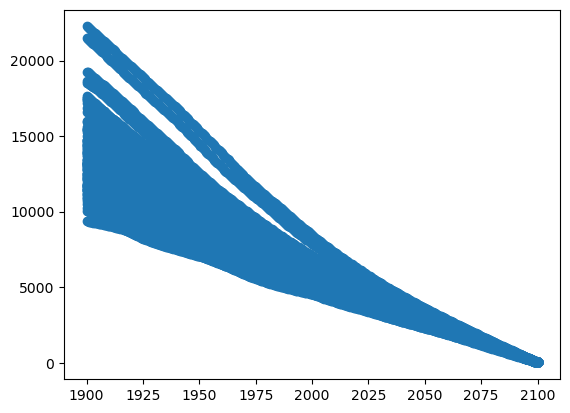

In [9]:
plt.scatter(dataframe["time"], dataframe["J"])
plt.show()

# Regression
The next part is trying to fit a linear regression model to the simulated data. We'll start by doing a simple linear regression to get some understanding of which variables are important. Then we can keep the linear regression model to compare a neural network model to. 

## Linear regression model

The model is trying to estimate J with $\hat J=\beta X$. Where $\beta=(X^TX)^{-1}X^TJ$

In [10]:
def get_beta(X, J):
    X = X / X.max()
    J = J / J.max()
    X = np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
    beta = np.linalg.inv(X.T @ X) @ X.T @ J
    return beta[0], beta[1:]

df = dataframe.apply(lambda x: x / x.max(), axis=0)

beta_0, beta_hat = get_beta(df.drop(columns=["J"]).to_numpy(), df["J"].to_numpy())

In [11]:
for i in range(len(beta_hat) - 1):
    print(state_variables[i], round(beta_hat[i], 3))  

print("time", round(beta_hat[-1], 2))


p1 -0.051
p2 -0.356
p3 0.057
p4 0.036
ic 0.361
sc 0.028
al 0.082
pal 0.041
uil 0.007
lfert -0.054
ppol -0.099
nr 0.165
time -5.68


*comments:* 
The biggest contributor is time, which might be expected as there are lower rewards for higher times. (time is also normalized here). Then we have ic, al, nr as the biggest contributors. 

### Error estimation

In [12]:
J_approx = beta_0 + (df.drop(columns=["J"]).to_numpy() @ beta_hat)
J_approx = J_approx.flatten()

In [13]:
error = (df["J"] - J_approx) ** 2

print(np.sum(error) / len(J_approx))

0.0005285754861713648


*comments:* Feels very small, not sure what more to do to verify this

## Trying to fit a neural net instead

In [14]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # testa denna på linear regression sen

The neural network model, input layer hidden layer output layer

In [15]:
class neuralNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(neuralNet, self).__init__()
        self.input_layer = nn.Linear(in_features=in_dim, out_features=64)
        self.hidden_layer = nn.Linear(in_features=64, out_features=32) 
        self.outLayer = nn.Linear(in_features=32, out_features=out_dim)

    def forward(self, x):
        # forward pass with relu activation function
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer(x))
        x = self.outLayer(x)
        return x

In [16]:
X = dataframe.drop(columns=["J"]).to_numpy()
J = dataframe["J"].to_numpy().reshape(-1,1)

X_train, X_test, J_train, J_test = train_test_split(X, J, test_size=0.2, random_state=42)

# normalizing
X_normalizer = StandardScaler()
X_train = X_normalizer.fit_transform(X_train)
X_test = X_normalizer.transform(X_test)
J_normalizer = StandardScaler()
J_train = J_normalizer.fit_transform(J_train)
J_test = J_normalizer.transform(J_test)

# turning into pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
J_train = torch.tensor(J_train, dtype=torch.float32)
J_test = torch.tensor(J_test, dtype=torch.float32)

In [19]:
model = neuralNet(X_train.shape[1], 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
model.train()

for epoch in range(epochs):
    J_pred = model.forward(X_train)
    loss = loss_func(J_pred, J_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print("Epoch", epoch+1, "Loss:", loss.item())
 

Epoch 20 Loss: 0.03589408099651337
Epoch 40 Loss: 0.012960787862539291
Epoch 60 Loss: 0.006212970241904259
Epoch 80 Loss: 0.003925396595150232
Epoch 100 Loss: 0.0029121097177267075


In [ ]:
model.eval()

with torch.no_grad():
    J_pred = model.forward(X_test)
    loss = loss_func(J_pred, J_test)

    print("Error on test set:", loss.item())

error on test set: 0.002794087864458561
